# 1.data input

In [1]:
from pandas import Series,DataFrame
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')  # link google drive

Mounted at /content/gdrive


In [3]:
import pandas as pd
df = pd.read_csv("/content/gdrive/My Drive/機器學習概論/hw2/student-mat.csv", sep= ';')

In [4]:
DataFrame(df)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,course,other,1,2,2,no,yes,yes,no,yes,yes,no,no,5,5,4,4,5,4,11,9,9,9
391,MS,M,17,U,LE3,T,3,1,services,services,course,mother,2,1,0,no,no,no,no,no,yes,yes,no,2,4,5,3,4,2,3,14,16,16
392,MS,M,21,R,GT3,T,1,1,other,other,course,other,1,1,3,no,no,no,no,no,yes,no,no,5,5,3,3,3,3,3,10,8,7
393,MS,M,18,R,LE3,T,3,2,services,other,course,mother,3,1,0,no,no,no,no,no,yes,yes,no,4,4,1,3,4,5,0,11,12,10


# 2.Data Preprocessing

In [5]:
from sklearn.utils import shuffle
df_dum = pd.get_dummies(df) # doing one hot
df_shuff = shuffle(df_dum)
DataFrame(df_shuff)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_no,schoolsup_yes,famsup_no,famsup_yes,paid_no,paid_yes,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
302,17,4,2,2,3,0,4,3,3,1,1,3,0,15,12,14,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,1,0,0,1,0,1,0,1,1,0
212,16,2,2,1,2,0,3,3,4,1,1,4,0,12,13,14,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,1,0,0,1,0,1,0,1,1,0
301,17,4,4,2,1,0,4,1,1,2,2,5,0,11,11,10,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,1,0
199,16,4,4,1,2,0,4,5,2,1,2,3,0,9,9,10,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,1,1,0,0,1,0,1,0,1,1,0
387,19,2,3,1,3,1,5,4,2,1,2,5,0,7,5,0,0,1,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,16,1,2,1,1,0,3,3,3,1,2,3,2,11,12,11,1,0,0,1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1
164,17,1,1,4,2,3,5,3,5,1,5,5,0,5,8,7,1,0,0,1,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0,1,0,0,1
43,15,2,2,1,1,0,5,4,1,1,1,1,0,8,8,11,1,0,0,1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,1,0,1,0,0,1,0,1,0,1,1,0
86,16,2,2,1,2,0,4,3,4,1,2,2,4,8,7,6,1,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,1,0,1,0


In [6]:
## binary classification for G3
df_b = df_shuff.copy(deep=False)
df_b.loc[df_b['G3']<=9,['G3']] = 'f'
df_b.loc[df_b['G3']!='f',['G3']] = 'p'
DataFrame(df_b['G3'])

,G3
302,p
212,p
301,p
199,p
387,f
...,...
186,p
164,f
43,p
86,f


In [7]:
## 5-level classification for G3
df_level = df_shuff.copy(deep=False)
cond_5 = df_shuff['G3']<=9
cond_4 = (df_shuff['G3']<12)&(df_shuff['G3']>9)
cond_3 = (df_shuff['G3']<14)&(df_shuff['G3']>11)
cond_2 = (df_shuff['G3']<16)&(df_shuff['G3']>13)
cond_1 = (df_shuff['G3']<21)&(df_shuff['G3']>15)
df_level.loc[cond_5,['G3']] = 'Country_V'
df_level.loc[cond_4,['G3']] = 'Country_IV'
df_level.loc[cond_3,['G3']] = 'Country_III'
df_level.loc[cond_2,['G3']] = 'Country_II'
df_level.loc[cond_1,['G3']] = 'Country_I'
DataFrame(df_level['G3'])

,G3
302,Country_II
212,Country_II
301,Country_IV
199,Country_IV
387,Country_V
...,...
186,Country_IV
164,Country_V
43,Country_IV
86,Country_V


# 3.Principal components analysis (PCA)

In [8]:
from sklearn.decomposition import PCA
def fun_pca(df_tmp1,df_tmp2):
  front1 = df_tmp1.loc[:,df_tmp1.columns[0:15]]
  front2 = df_tmp2.loc[:,df_tmp2.columns[0:15]]
  tail2 = df_tmp2.loc[:,df_tmp2.columns[15:59]]
  pca = PCA()
  pca.fit(front1)
  variances = pca.explained_variance_
  
  thresh=variances[11] # 小於該閾值的認為該特徵不重要，可刪除
  useful_features = variances>thresh

  pca.n_components = np.sum(useful_features) # 設定PCA的新特徵數量
  data_b_pca=pca.fit_transform(front2) # 進行PCA降維之後的新資料集
  header = front2.columns[0:data_b_pca.shape[1]]
  df_tmp_pca = DataFrame(data_b_pca,columns = header)
  tail2.reset_index(inplace=True, drop=True)
  total_pd = pd.concat([df_tmp_pca, tail2], axis = 1)
  return total_pd

# 4-1.Model Construction(Decision Tree)

In [9]:
from sklearn.tree import DecisionTreeClassifier
model_dt = DecisionTreeClassifier()

# 4-2.Model Construction(Random Forest)

In [10]:
from sklearn.ensemble import RandomForestClassifier
model_RF_5 = RandomForestClassifier(n_estimators=5)
model_RF_100 = RandomForestClassifier(n_estimators=100)
model_RF_1000 = RandomForestClassifier(n_estimators=1000)

# 4-3.Model Construction(K-Nearest)

In [11]:
from sklearn.neighbors import KNeighborsClassifier
model_KNN_5 = KNeighborsClassifier(n_neighbors=5)
model_KNN_15 = KNeighborsClassifier(n_neighbors=15)
model_KNN_100 = KNeighborsClassifier(n_neighbors=100)

# 5.Validation

In [12]:
def validation(df_origin):
  df_tmp = df_origin.copy(deep=False)
  n = int(df_tmp.shape[0]/3)
  part1=df_tmp.iloc[0:n]
  part2=df_tmp.iloc[n:2*n]
  part3=df_tmp.iloc[2*n:df_tmp.shape[0]]
  fold1=part1.append(part2)
  fold2=part1.append(part3)
  fold3=part2.append(part3)

  global fold1_X_train, fold1_y_train, fold1_X_test, fold1_y_test
  global fold2_X_train, fold2_y_train, fold2_X_test, fold2_y_test
  global fold3_X_train, fold3_y_train, fold3_X_test, fold3_y_test
  fold1_X_train = fold1.drop(['G3'], axis=1)
  fold1_y_train = fold1['G3']
  fold1_X_test = part3.drop(['G3'], axis=1)
  fold1_y_test = part3['G3']

  fold2_X_train = fold2.drop(['G3'], axis=1)
  fold2_y_train = fold2['G3']
  fold2_X_test = part2.drop(['G3'], axis=1)
  fold2_y_test = part2['G3']

  fold3_X_train = fold3.drop(['G3'], axis=1)
  fold3_y_train = fold3['G3']
  fold3_X_test = part1.drop(['G3'], axis=1)
  fold3_y_test = part1['G3']

# 6-1-1.Results(binary with Decision Tree)

In [13]:
from sklearn.metrics import confusion_matrix
import sklearn.metrics
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.metrics import classification_report

In [14]:
def result_func(model, fold1_X_train_tmp, fold1_X_test_tmp, fold1_y_train_tmp,fold1_y_test_tmp,
           fold2_X_train_tmp, fold2_X_test_tmp, fold2_y_train_tmp, fold2_y_test_tmp,
           fold3_X_train_tmp, fold3_X_test_tmp, fold3_y_train_tmp, fold3_y_test_tmp):
  model.fit(fold1_X_train_tmp, fold1_y_train_tmp)
  fold1_y_pred_model = model.predict(fold1_X_test_tmp)
  fold1_c = confusion_matrix(fold1_y_test_tmp, fold1_y_pred_model)
  fold1_acc = round(accuracy_score(fold1_y_test_tmp, fold1_y_pred_model)*100,2)
  fold1_rec = sklearn.metrics.recall_score(fold1_y_test_tmp, fold1_y_pred_model, average=None)
  fold1_pre = sklearn.metrics.precision_score(fold1_y_test_tmp, fold1_y_pred_model, average=None)

  model.fit(fold2_X_train_tmp, fold2_y_train_tmp)
  fold2_y_pred_model = model.predict(fold2_X_test_tmp)
  fold2_c = confusion_matrix(fold2_y_test_tmp, fold2_y_pred_model)
  fold2_acc = round(accuracy_score(fold2_y_test_tmp, fold2_y_pred_model)*100,2)
  fold2_rec = sklearn.metrics.recall_score(fold2_y_test_tmp, fold2_y_pred_model, average=None)
  fold2_pre = sklearn.metrics.precision_score(fold2_y_test_tmp, fold2_y_pred_model, average=None)

  model.fit(fold3_X_train_tmp, fold3_y_train_tmp)
  fold3_y_pred_model = model.predict(fold3_X_test_tmp)
  fold3_c = confusion_matrix(fold3_y_test_tmp, fold3_y_pred_model)
  fold3_acc = round(accuracy_score(fold3_y_test_tmp, fold3_y_pred_model)*100,2)
  fold3_rec = sklearn.metrics.recall_score(fold3_y_test_tmp, fold3_y_pred_model, average=None)
  fold3_pre = sklearn.metrics.precision_score(fold3_y_test_tmp, fold3_y_pred_model, average=None)
  global c_ave, acc_ave, rec_ave, pre_ave
  c_ave = (fold1_c+fold2_c+fold3_c)/3
  acc_ave = round((fold1_acc+fold2_acc+fold3_acc)/3,2)
  rec_ave = (fold1_rec+fold2_rec+fold3_rec)/3
  pre_ave = (fold1_pre+fold2_pre+fold3_pre)/3 

In [15]:
# binary with decision tree with pca
validation(df_b)
fold1_X_train_pca = fun_pca(fold1_X_train, fold1_X_train)
fold1_X_test_pca = fun_pca(fold1_X_train, fold1_X_test)
fold2_X_train_pca = fun_pca(fold2_X_train, fold2_X_train)
fold2_X_test_pca = fun_pca(fold2_X_train, fold2_X_test)
fold3_X_train_pca = fun_pca(fold3_X_train, fold3_X_train)
fold3_X_test_pca = fun_pca(fold3_X_train, fold3_X_test)
result_func(model_dt, fold1_X_train_pca, fold1_X_test_pca, fold1_y_train, fold1_y_test,
       fold2_X_train_pca, fold2_X_test_pca, fold2_y_train, fold2_y_test,
       fold3_X_train_pca, fold3_X_test_pca, fold3_y_train, fold3_y_test)
c_ave_b_pca = c_ave
acc_ave_b_pca = acc_ave
rec_ave_b_pca = rec_ave
pre_ave_b_pca = pre_ave

#binary with decision tree without pca
validation(df_b)
result_func(model_dt, fold1_X_train, fold1_X_test, fold1_y_train, fold1_y_test,
       fold2_X_train, fold2_X_test, fold2_y_train, fold2_y_test,
       fold3_X_train, fold3_X_test, fold3_y_train, fold3_y_test)
c_ave_b = c_ave
acc_ave_b = acc_ave
rec_ave_b = rec_ave
pre_ave_b = pre_ave
print("binary label with Decision Tree:")
print("\nwith pca:\n", "Accuracy: {}%".format(acc_ave_b_pca))
print("\nconfusion matrix:\n", c_ave_b_pca)
table_head = ["class Name", "Sensitivity(Recall)", "Precision"]
table_data = [["fail", "{}%".format(round(rec_ave_b_pca[0]*100,2)), "{}%".format(round(pre_ave_b_pca[0]*100,2))],
        ["pass", "{}%".format(round(rec_ave_b_pca[1]*100,2)), "{}%".format(round(pre_ave_b_pca[1]*100,2))]]
print("\n",tabulate(table_data, headers=table_head, tablefmt="grid"))

print("\nwithout pca:\n", "Accuracy: {}%".format(acc_ave_b))
print("\nconfusion matrix:\n", c_ave_b)
table_data = [["fail", "{}%".format(round(rec_ave_b[0]*100,2)), "{}%".format(round(pre_ave_b[0]*100,2))],
        ["pass", "{}%".format(round(rec_ave_b[1]*100,2)), "{}%".format(round(pre_ave_b[1]*100,2))]]
print("\n",tabulate(table_data, headers=table_head, tablefmt="grid"))


binary label with Decision Tree:

with pca:
 Accuracy: 83.81%

confusion matrix:
 [[32.         11.33333333]
 [10.         78.33333333]]

 +--------------+-----------------------+-------------+
| class Name   | Sensitivity(Recall)   | Precision   |
+==============+=======================+=============+
| fail         | 74.06%                | 76.87%      |
+--------------+-----------------------+-------------+
| pass         | 88.91%                | 87.53%      |
+--------------+-----------------------+-------------+

without pca:
 Accuracy: 85.59%

confusion matrix:
 [[34.          9.33333333]
 [ 9.66666667 78.66666667]]

 +--------------+-----------------------+-------------+
| class Name   | Sensitivity(Recall)   | Precision   |
+==============+=======================+=============+
| fail         | 78.23%                | 77.78%      |
+--------------+-----------------------+-------------+
| pass         | 89.17%                | 89.39%      |
+--------------+---------------------

					220th data's G2 is:  6


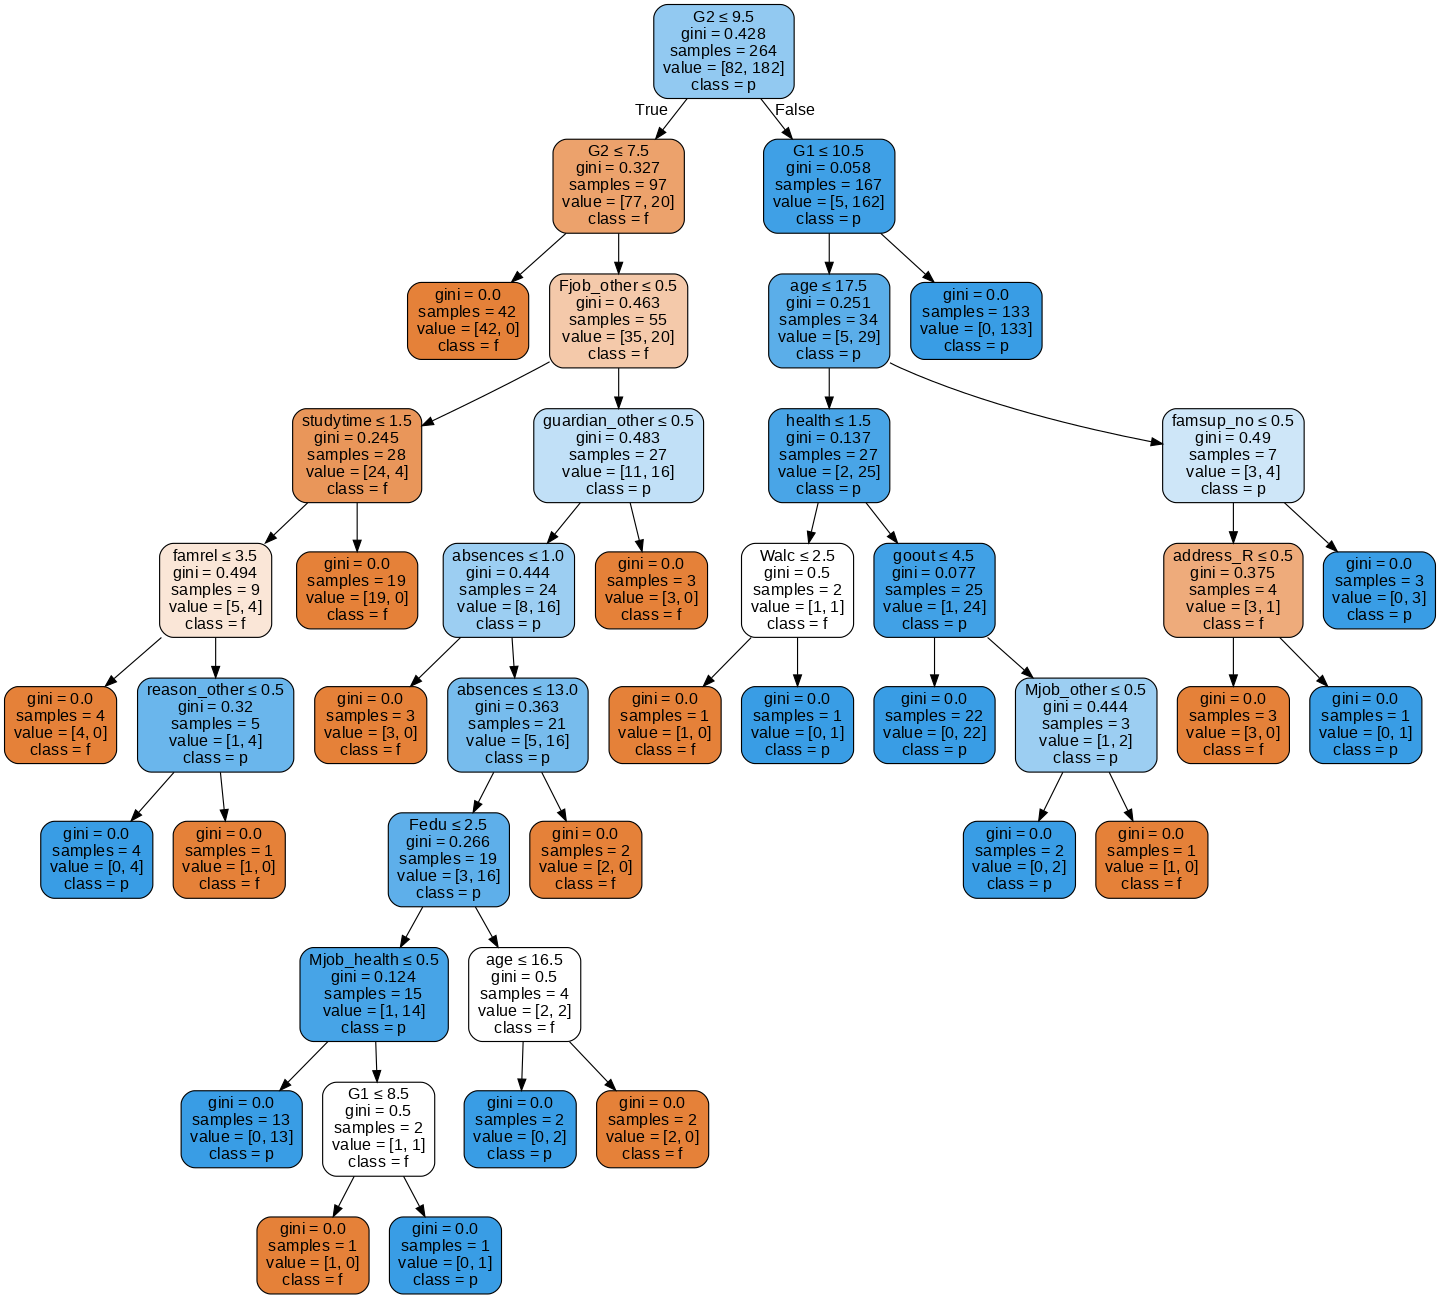

In [16]:
from sklearn.tree import export_graphviz
import os
import graphviz
import pydotplus
from IPython.display import display,Image
print("\t\t\t\t\t220th data's G2 is: ",df_b['G2'][0])
dot_data = export_graphviz(model_dt, out_file=None, 
 feature_names=fold1_X_train.columns, 
 filled=True, rounded=True, 
 special_characters=True,class_names=model_dt.classes_)

graph = pydotplus.graph_from_dot_data(dot_data)
graph.set_size('"15,15!"')
display(Image(graph.create_png()))

# 6-1-2.Results(5-level with Decision Tree)

In [17]:
# 5-level with decision tree with pca
validation(df_level)
fold1_X_train_pca = fun_pca(fold1_X_train, fold1_X_train)
fold1_X_test_pca = fun_pca(fold1_X_train, fold1_X_test)
fold2_X_train_pca = fun_pca(fold2_X_train, fold2_X_train)
fold2_X_test_pca = fun_pca(fold2_X_train, fold2_X_test)
fold3_X_train_pca = fun_pca(fold3_X_train, fold3_X_train)
fold3_X_test_pca = fun_pca(fold3_X_train, fold3_X_test)
result_func(model_dt, fold1_X_train_pca, fold1_X_test_pca, fold1_y_train, fold1_y_test,
       fold2_X_train_pca, fold2_X_test_pca, fold2_y_train, fold2_y_test,
       fold3_X_train_pca, fold3_X_test_pca, fold3_y_train, fold3_y_test)
c_ave_level_pca = c_ave
acc_ave_level_pca = acc_ave
rec_ave_level_pca = rec_ave
pre_ave_level_pca = pre_ave

#5-level with decision tree without pca
validation(df_level)
result_func(model_dt, fold1_X_train, fold1_X_test, fold1_y_train, fold1_y_test,
       fold2_X_train, fold2_X_test, fold2_y_train, fold2_y_test,
       fold3_X_train, fold3_X_test, fold3_y_train, fold3_y_test)
c_ave_level = c_ave
acc_ave_level = acc_ave
rec_ave_level = rec_ave
pre_ave_level = pre_ave
print("5-level label with Decision Tree:")
print("\nwith pca:\n", "Accuracy: {}%".format(acc_ave_level_pca))
print("\nconfusion matrix:\n", c_ave_level_pca)
table_head = ["class Name", "Sensitivity(Recall)", "Precision"]
table_data = [["Country_I(excellent)", "{}%".format(round(rec_ave_level_pca[0]*100,2)), "{}%".format(round(pre_ave_level_pca[0]*100,2))],
        ["Country_II(good)", "{}%".format(round(rec_ave_level_pca[1]*100,2)), "{}%".format(round(pre_ave_level_pca[1]*100,2))],
        ["Country_III(satisfactory)", "{}%".format(round(rec_ave_level_pca[2]*100,2)), "{}%".format(round(pre_ave_level_pca[2]*100,2))],
        ["Country_IV(sufficient)", "{}%".format(round(rec_ave_level_pca[3]*100,2)), "{}%".format(round(pre_ave_level_pca[3]*100,2))],
        ["Country_V(fail)", "{}%".format(round(rec_ave_level_pca[4]*100,2)), "{}%".format(round(pre_ave_level_pca[4]*100,2))]]
print("\n",tabulate(table_data, headers=table_head, tablefmt="grid"))

print("\nwithout pca:\n", "Accuracy: {}%".format(acc_ave_level))
print("\nconfusion matrix:\n", c_ave_level)
table_data = [["Country_I(excellent)", "{}%".format(round(rec_ave_level[0]*100,2)), "{}%".format(round(pre_ave_level[0]*100,2))],
        ["Country_II(good)", "{}%".format(round(rec_ave_level[1]*100,2)), "{}%".format(round(pre_ave_level[1]*100,2))],
        ["Country_III(satisfactory)", "{}%".format(round(rec_ave_level[2]*100,2)), "{}%".format(round(pre_ave_level[2]*100,2))],
        ["Country_IV(sufficient)", "{}%".format(round(rec_ave_level[3]*100,2)), "{}%".format(round(pre_ave_level[3]*100,2))],
        ["Country_V(fail)", "{}%".format(round(rec_ave_level[4]*100,2)), "{}%".format(round(pre_ave_level[4]*100,2))]]
print("\n",tabulate(table_data, headers=table_head, tablefmt="grid"))


5-level label with Decision Tree:

with pca:
 Accuracy: 58.48%

confusion matrix:
 [[ 8.66666667  4.33333333  0.33333333  0.          0.        ]
 [ 4.         11.33333333  3.33333333  1.33333333  0.        ]
 [ 0.66666667  6.33333333  8.          5.          0.66666667]
 [ 0.          1.          6.         16.66666667 10.66666667]
 [ 0.          0.          1.         10.         32.33333333]]

 +---------------------------+-----------------------+-------------+
| class Name                | Sensitivity(Recall)   | Precision   |
+===========================+=======================+=============+
| Country_I(excellent)      | 67.99%                | 65.2%       |
+---------------------------+-----------------------+-------------+
| Country_II(good)          | 56.94%                | 49.78%      |
+---------------------------+-----------------------+-------------+
| Country_III(satisfactory) | 38.67%                | 43.42%      |
+---------------------------+-----------------------+--

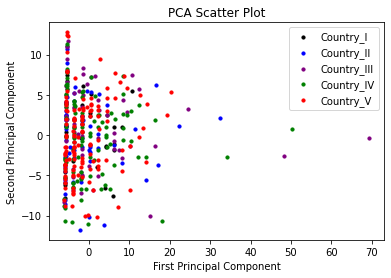

In [18]:
import matplotlib.pyplot as plt

# In 5-Level classification, reduce the data dimension to 2 using PCA and draw a scatter plot
pca_2 = PCA(n_components=2)
data = df_level.drop(['G3'], axis=1)
data_pca=pca_2.fit_transform(data)
header = df_level.columns[0:2]
df_pca = DataFrame(data_pca,columns = header)
df_pca['G3']=df_level['G3']
label = ['Country_I', 'Country_II', 'Country_III', 'Country_IV', 'Country_V']
colors = ['black', 'blue', 'purple', 'green', 'red']
for i in range(len(colors)):
    df_tmp = df_pca[df_pca['G3'] == label[i]]
    x = df_tmp[df_pca.columns[0]]
    y = df_tmp[df_pca.columns[1]]
    plt.scatter(x, y, c=colors[i], s=10)
plt.legend(label)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title("PCA Scatter Plot")
plt.show()

# 6-2-1.Results(binary with Random Forest)

In [19]:
# binary with Random Forest with pca
validation(df_b)
fold1_X_train_pca = fun_pca(fold1_X_train, fold1_X_train)
fold1_X_test_pca = fun_pca(fold1_X_train, fold1_X_test)
fold2_X_train_pca = fun_pca(fold2_X_train, fold2_X_train)
fold2_X_test_pca = fun_pca(fold2_X_train, fold2_X_test)
fold3_X_train_pca = fun_pca(fold3_X_train, fold3_X_train)
fold3_X_test_pca = fun_pca(fold3_X_train, fold3_X_test)
result_func(model_RF_100, fold1_X_train_pca, fold1_X_test_pca, fold1_y_train, fold1_y_test,
       fold2_X_train_pca, fold2_X_test_pca, fold2_y_train, fold2_y_test,
       fold3_X_train_pca, fold3_X_test_pca, fold3_y_train, fold3_y_test)
c_ave_b_pca = c_ave
acc_ave_b_pca = acc_ave
rec_ave_b_pca = rec_ave
pre_ave_b_pca = pre_ave

#binary with Random Forest without pca
validation(df_b)
result_func(model_RF_100, fold1_X_train, fold1_X_test, fold1_y_train, fold1_y_test,
       fold2_X_train, fold2_X_test, fold2_y_train, fold2_y_test,
       fold3_X_train, fold3_X_test, fold3_y_train, fold3_y_test)
c_ave_b = c_ave
acc_ave_b = acc_ave
rec_ave_b = rec_ave
pre_ave_b = pre_ave
print("binary label with Random Forest(100):")
print("\nwith pca:\n", "Accuracy: {}%".format(acc_ave_b_pca))
print("\nconfusion matrix:\n", c_ave_b_pca)
table_head = ["class Name", "Sensitivity(Recall)", "Precision"]
table_data = [["fail", "{}%".format(round(rec_ave_b_pca[0]*100,2)), "{}%".format(round(pre_ave_b_pca[0]*100,2))],
        ["pass", "{}%".format(round(rec_ave_b_pca[1]*100,2)), "{}%".format(round(pre_ave_b_pca[1]*100,2))]]
print("\n",tabulate(table_data, headers=table_head, tablefmt="grid"))

print("\nwithout pca:\n", "Accuracy: {}%".format(acc_ave_b))
print("\nconfusion matrix:\n", c_ave_b)
table_data = [["fail", "{}%".format(round(rec_ave_b[0]*100,2)), "{}%".format(round(pre_ave_b[0]*100,2))],
        ["pass", "{}%".format(round(rec_ave_b[1]*100,2)), "{}%".format(round(pre_ave_b[1]*100,2))]]
print("\n",tabulate(table_data, headers=table_head, tablefmt="grid"))

binary label with Random Forest(100):

with pca:
 Accuracy: 85.34%

confusion matrix:
 [[31.66666667 11.66666667]
 [ 7.66666667 80.66666667]]

 +--------------+-----------------------+-------------+
| class Name   | Sensitivity(Recall)   | Precision   |
+==============+=======================+=============+
| fail         | 73.85%                | 83.38%      |
+--------------+-----------------------+-------------+
| pass         | 91.7%                 | 87.69%      |
+--------------+-----------------------+-------------+

without pca:
 Accuracy: 91.41%

confusion matrix:
 [[38.33333333  5.        ]
 [ 6.33333333 82.        ]]

 +--------------+-----------------------+-------------+
| class Name   | Sensitivity(Recall)   | Precision   |
+==============+=======================+=============+
| fail         | 88.62%                | 85.97%      |
+--------------+-----------------------+-------------+
| pass         | 93.0%                 | 94.25%      |
+--------------+----------------

# 6-2-2.Results(5-level with Random Forest)

In [20]:
# 5-level with Random Forest with pca
validation(df_level)
fold1_X_train_pca = fun_pca(fold1_X_train, fold1_X_train)
fold1_X_test_pca = fun_pca(fold1_X_train, fold1_X_test)
fold2_X_train_pca = fun_pca(fold2_X_train, fold2_X_train)
fold2_X_test_pca = fun_pca(fold2_X_train, fold2_X_test)
fold3_X_train_pca = fun_pca(fold3_X_train, fold3_X_train)
fold3_X_test_pca = fun_pca(fold3_X_train, fold3_X_test)
result_func(model_RF_100, fold1_X_train_pca, fold1_X_test_pca, fold1_y_train, fold1_y_test,
       fold2_X_train_pca, fold2_X_test_pca, fold2_y_train, fold2_y_test,
       fold3_X_train_pca, fold3_X_test_pca, fold3_y_train, fold3_y_test)
c_ave_level_pca = c_ave
acc_ave_level_pca = acc_ave
rec_ave_level_pca = rec_ave
pre_ave_level_pca = pre_ave

#5-level with Random Forest without pca
validation(df_level)
result_func(model_RF_100, fold1_X_train, fold1_X_test, fold1_y_train, fold1_y_test,
       fold2_X_train, fold2_X_test, fold2_y_train, fold2_y_test,
       fold3_X_train, fold3_X_test, fold3_y_train, fold3_y_test)
c_ave_level = c_ave
acc_ave_level = acc_ave
rec_ave_level = rec_ave
pre_ave_level = pre_ave
print("5-level label with Random Forest(100):")
print("\nwith pca:\n", "Accuracy: {}%".format(acc_ave_level_pca))
print("\nconfusion matrix:\n", c_ave_level_pca)
table_head = ["class Name", "Sensitivity(Recall)", "Precision"]
table_data = [["Country_I(excellent)", "{}%".format(round(rec_ave_level_pca[0]*100,2)), "{}%".format(round(pre_ave_level_pca[0]*100,2))],
        ["Country_II(good)", "{}%".format(round(rec_ave_level_pca[1]*100,2)), "{}%".format(round(pre_ave_level_pca[1]*100,2))],
        ["Country_III(satisfactory)", "{}%".format(round(rec_ave_level_pca[2]*100,2)), "{}%".format(round(pre_ave_level_pca[2]*100,2))],
        ["Country_IV(sufficient)", "{}%".format(round(rec_ave_level_pca[3]*100,2)), "{}%".format(round(pre_ave_level_pca[3]*100,2))],
        ["Country_V(fail)", "{}%".format(round(rec_ave_level_pca[4]*100,2)), "{}%".format(round(pre_ave_level_pca[4]*100,2))]]
print("\n",tabulate(table_data, headers=table_head, tablefmt="grid"))

print("\nwithout pca:\n", "Accuracy: {}%".format(acc_ave_level))
print("\nconfusion matrix:\n", c_ave_level)
table_data = [["Country_I(excellent)", "{}%".format(round(rec_ave_level[0]*100,2)), "{}%".format(round(pre_ave_level[0]*100,2))],
        ["Country_II(good)", "{}%".format(round(rec_ave_level[1]*100,2)), "{}%".format(round(pre_ave_level[1]*100,2))],
        ["Country_III(satisfactory)", "{}%".format(round(rec_ave_level[2]*100,2)), "{}%".format(round(pre_ave_level[2]*100,2))],
        ["Country_IV(sufficient)", "{}%".format(round(rec_ave_level[3]*100,2)), "{}%".format(round(pre_ave_level[3]*100,2))],
        ["Country_V(fail)", "{}%".format(round(rec_ave_level[4]*100,2)), "{}%".format(round(pre_ave_level[4]*100,2))]]
print("\n",tabulate(table_data, headers=table_head, tablefmt="grid"))


5-level label with Random Forest(100):

with pca:
 Accuracy: 61.02%

confusion matrix:
 [[ 4.66666667  6.66666667  1.          0.66666667  0.33333333]
 [ 3.         12.          2.33333333  2.33333333  0.33333333]
 [ 0.          6.          8.          6.33333333  0.33333333]
 [ 0.          1.33333333  3.         18.         12.        ]
 [ 0.          0.          0.66666667  5.         37.66666667]]

 +---------------------------+-----------------------+-------------+
| class Name                | Sensitivity(Recall)   | Precision   |
+===========================+=======================+=============+
| Country_I(excellent)      | 39.31%                | 71.52%      |
+---------------------------+-----------------------+-------------+
| Country_II(good)          | 62.22%                | 50.11%      |
+---------------------------+-----------------------+-------------+
| Country_III(satisfactory) | 42.11%                | 51.07%      |
+---------------------------+---------------------

In [21]:
#compare 5-level with Random Forest without pca of 5,15,100
acc_ave_level_100 = acc_ave_level
validation(df_level)
result_func(model_RF_5, fold1_X_train, fold1_X_test, fold1_y_train, fold1_y_test,
       fold2_X_train, fold2_X_test, fold2_y_train, fold2_y_test,
       fold3_X_train, fold3_X_test, fold3_y_train, fold3_y_test)
acc_ave_level_5 = acc_ave

result_func(model_RF_1000, fold1_X_train, fold1_X_test, fold1_y_train, fold1_y_test,
       fold2_X_train, fold2_X_test, fold2_y_train, fold2_y_test,
       fold3_X_train, fold3_X_test, fold3_y_train, fold3_y_test)
acc_ave_level_1000 = acc_ave
print("5-level label with Random Forest without PCA:")

table_head = ["class Name", "Accuracy"]

table_data = [["k = 5", "{}%".format(acc_ave_level_5)],
        ["k = 100", "{}%".format(acc_ave_level_100)],
        ["k = 1000", "{}%".format(acc_ave_level_1000)]]
print("\n",tabulate(table_data, headers=table_head, tablefmt="grid"))


5-level label with Random Forest without PCA:

 +--------------+------------+
| class Name   | Accuracy   |
+==============+============+
| k = 5        | 52.99%     |
+--------------+------------+
| k = 100      | 65.57%     |
+--------------+------------+
| k = 1000     | 69.37%     |
+--------------+------------+


# 6-3-1.Results(binary with KNN)

In [22]:
# binary with KNN with pca
validation(df_b)
fold1_X_train_pca = fun_pca(fold1_X_train, fold1_X_train)
fold1_X_test_pca = fun_pca(fold1_X_train, fold1_X_test)
fold2_X_train_pca = fun_pca(fold2_X_train, fold2_X_train)
fold2_X_test_pca = fun_pca(fold2_X_train, fold2_X_test)
fold3_X_train_pca = fun_pca(fold3_X_train, fold3_X_train)
fold3_X_test_pca = fun_pca(fold3_X_train, fold3_X_test)
result_func(model_KNN_5, fold1_X_train_pca, fold1_X_test_pca, fold1_y_train, fold1_y_test,
       fold2_X_train_pca, fold2_X_test_pca, fold2_y_train, fold2_y_test,
       fold3_X_train_pca, fold3_X_test_pca, fold3_y_train, fold3_y_test)
c_ave_b_pca = c_ave
acc_ave_b_pca = acc_ave
rec_ave_b_pca = rec_ave
pre_ave_b_pca = pre_ave

#binary with KNN without pca
validation(df_b)
result_func(model_KNN_5, fold1_X_train, fold1_X_test, fold1_y_train, fold1_y_test,
       fold2_X_train, fold2_X_test, fold2_y_train, fold2_y_test,
       fold3_X_train, fold3_X_test, fold3_y_train, fold3_y_test)
c_ave_b = c_ave
acc_ave_b = acc_ave
rec_ave_b = rec_ave
pre_ave_b = pre_ave
print("binary label with KNN(5):")
print("\nwith pca:\n", "Accuracy: {}%".format(acc_ave_b_pca))
print("\nconfusion matrix:\n", c_ave_b_pca)
table_head = ["class Name", "Sensitivity(Recall)", "Precision"]
table_data = [["fail", "{}%".format(round(rec_ave_b_pca[0]*100,2)), "{}%".format(round(pre_ave_b_pca[0]*100,2))],
        ["pass", "{}%".format(round(rec_ave_b_pca[1]*100,2)), "{}%".format(round(pre_ave_b_pca[1]*100,2))]]
print("\n",tabulate(table_data, headers=table_head, tablefmt="grid"))

print("\nwithout pca:\n", "Accuracy: {}%".format(acc_ave_b))
print("\nconfusion matrix:\n", c_ave_b)
table_data = [["fail", "{}%".format(round(rec_ave_b[0]*100,2)), "{}%".format(round(pre_ave_b[0]*100,2))],
        ["pass", "{}%".format(round(rec_ave_b[1]*100,2)), "{}%".format(round(pre_ave_b[1]*100,2))]]
print("\n",tabulate(table_data, headers=table_head, tablefmt="grid"))

binary label with KNN(5):

with pca:
 Accuracy: 85.83%

confusion matrix:
 [[33.33333333 10.        ]
 [ 8.66666667 79.66666667]]

 +--------------+-----------------------+-------------+
| class Name   | Sensitivity(Recall)   | Precision   |
+==============+=======================+=============+
| fail         | 77.32%                | 80.12%      |
+--------------+-----------------------+-------------+
| pass         | 90.37%                | 89.0%       |
+--------------+-----------------------+-------------+

without pca:
 Accuracy: 86.33%

confusion matrix:
 [[33.66666667  9.66666667]
 [ 8.33333333 80.        ]]

 +--------------+-----------------------+-------------+
| class Name   | Sensitivity(Recall)   | Precision   |
+==============+=======================+=============+
| fail         | 77.77%                | 80.21%      |
+--------------+-----------------------+-------------+
| pass         | 90.68%                | 89.21%      |
+--------------+-----------------------+----

# 6-2-2.Results(5-level with KNN)

In [ ]:
# 5-level with KNN with pca
validation(df_level)
fold1_X_train_pca = fun_pca(fold1_X_train, fold1_X_train)
fold1_X_test_pca = fun_pca(fold1_X_train, fold1_X_test)
fold2_X_train_pca = fun_pca(fold2_X_train, fold2_X_train)
fold2_X_test_pca = fun_pca(fold2_X_train, fold2_X_test)
fold3_X_train_pca = fun_pca(fold3_X_train, fold3_X_train)
fold3_X_test_pca = fun_pca(fold3_X_train, fold3_X_test)
result_func(model_KNN_5, fold1_X_train_pca, fold1_X_test_pca, fold1_y_train, fold1_y_test,
       fold2_X_train_pca, fold2_X_test_pca, fold2_y_train, fold2_y_test,
       fold3_X_train_pca, fold3_X_test_pca, fold3_y_train, fold3_y_test)
c_ave_level_pca = c_ave
acc_ave_level_pca = acc_ave
rec_ave_level_pca = rec_ave
pre_ave_level_pca = pre_ave

#5-level with KNN without pca
validation(df_level)
result_func(model_KNN_5, fold1_X_train, fold1_X_test, fold1_y_train, fold1_y_test,
       fold2_X_train, fold2_X_test, fold2_y_train, fold2_y_test,
       fold3_X_train, fold3_X_test, fold3_y_train, fold3_y_test)
c_ave_level = c_ave
acc_ave_level = acc_ave
rec_ave_level = rec_ave
pre_ave_level = pre_ave
print("5-level label with KNN(5):")
print("\nwith pca:\n", "Accuracy: {}%".format(acc_ave_level_pca))
print("\nconfusion matrix:\n", c_ave_level_pca)
table_head = ["class Name", "Sensitivity(Recall)", "Precision"]
table_data = [["Country_I(excellent)", "{}%".format(round(rec_ave_level_pca[0]*100,2)), "{}%".format(round(pre_ave_level_pca[0]*100,2))],
        ["Country_II(good)", "{}%".format(round(rec_ave_level_pca[1]*100,2)), "{}%".format(round(pre_ave_level_pca[1]*100,2))],
        ["Country_III(satisfactory)", "{}%".format(round(rec_ave_level_pca[2]*100,2)), "{}%".format(round(pre_ave_level_pca[2]*100,2))],
        ["Country_IV(sufficient)", "{}%".format(round(rec_ave_level_pca[3]*100,2)), "{}%".format(round(pre_ave_level_pca[3]*100,2))],
        ["Country_V(fail)", "{}%".format(round(rec_ave_level_pca[4]*100,2)), "{}%".format(round(pre_ave_level_pca[4]*100,2))]]
print("\n",tabulate(table_data, headers=table_head, tablefmt="grid"))

print("\nwithout pca:\n", "Accuracy: {}%".format(acc_ave_level))
print("\nconfusion matrix:\n", c_ave_level)
table_data = [["Country_I(excellent)", "{}%".format(round(rec_ave_level[0]*100,2)), "{}%".format(round(pre_ave_level[0]*100,2))],
        ["Country_II(good)", "{}%".format(round(rec_ave_level[1]*100,2)), "{}%".format(round(pre_ave_level[1]*100,2))],
        ["Country_III(satisfactory)", "{}%".format(round(rec_ave_level[2]*100,2)), "{}%".format(round(pre_ave_level[2]*100,2))],
        ["Country_IV(sufficient)", "{}%".format(round(rec_ave_level[3]*100,2)), "{}%".format(round(pre_ave_level[3]*100,2))],
        ["Country_V(fail)", "{}%".format(round(rec_ave_level[4]*100,2)), "{}%".format(round(pre_ave_level[4]*100,2))]]
print("\n",tabulate(table_data, headers=table_head, tablefmt="grid"))


5-level label with KNN(5):

with pca:
 Accuracy: 54.67%

confusion matrix:
 [[ 6.66666667  6.33333333  0.33333333  0.          0.        ]
 [ 3.66666667 12.          3.33333333  1.          0.        ]
 [ 0.          7.          6.66666667  6.33333333  0.66666667]
 [ 0.          1.66666667  8.         16.66666667  8.        ]
 [ 0.          0.          1.33333333 12.         30.        ]]

 +---------------------------+-----------------------+-------------+
| class Name                | Sensitivity(Recall)   | Precision   |
+===========================+=======================+=============+
| Country_I(excellent)      | 51.57%                | 63.97%      |
+---------------------------+-----------------------+-------------+
| Country_II(good)          | 63.89%                | 47.72%      |
+---------------------------+-----------------------+-------------+
| Country_III(satisfactory) | 33.59%                | 31.0%       |
+---------------------------+-----------------------+---------

In [ ]:
#compare 5-level with KNN without pca of 5,15,100
acc_ave_level_5 = acc_ave_level
validation(df_level)
result_func(model_KNN_15, fold1_X_train, fold1_X_test, fold1_y_train, fold1_y_test,
       fold2_X_train, fold2_X_test, fold2_y_train, fold2_y_test,
       fold3_X_train, fold3_X_test, fold3_y_train, fold3_y_test)
acc_ave_level_15 = acc_ave

result_func(model_KNN_100, fold1_X_train, fold1_X_test, fold1_y_train, fold1_y_test,
       fold2_X_train, fold2_X_test, fold2_y_train, fold2_y_test,
       fold3_X_train, fold3_X_test, fold3_y_train, fold3_y_test)
acc_ave_level_100 = acc_ave
print("5-level label with KNN without PCA:")

table_head_com = ["class Name", "Accuracy"]

table_data_com = [["k = 5", "{}%".format(acc_ave_level_5)],
        ["k = 15", "{}%".format(acc_ave_level_15)],
        ["k = 100", "{}%".format(acc_ave_level_100)]]
print("\n",tabulate(table_data_com, headers=table_head_com, tablefmt="grid"))

5-level label with KNN without PCA:

 +--------------+------------+
| class Name   | Accuracy   |
+==============+============+
| k = 5        | 61.02%     |
+--------------+------------+
| k = 15       | 62.04%     |
+--------------+------------+
| k = 100      | 49.62%     |
+--------------+------------+


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


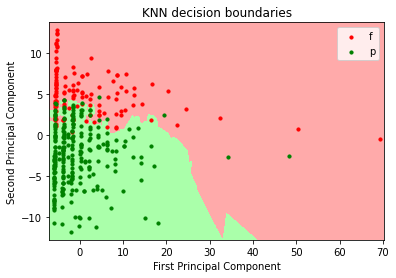

In [23]:
#one arbitrary sample in testing set and bonus with binary and PCA ofKNN
from sklearn import neighbors
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#003300'])
pca_2 = PCA(n_components=2)
data = df_b.drop(['G3'], axis=1)
X = pca_2.fit_transform(data)
# header = df_b.columns[0:2]
# df_pca = DataFrame(X,columns = header)
# df_pca['G3']=df_b['G3']
label = df_b['G3']
y = label.values
label_name = ['f', 'p']
model_KNN_5.fit(X, y)
h = .02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = model_KNN_5.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
Z_int = np.zeros(Z.shape, dtype = int)
for i in range(Z.shape[0]):
  for j in range(Z.shape[1]):
    if(Z[i][j]=='f'):
      Z_int[i][j]=0
    else:
      Z_int[i][j]=1

y_int = np.zeros(y.size, dtype = int)
for i in range(y.size):
  if(y[i]=='f'):
    y_int[i]=0
  else:
    y_int[i]=1

plt.contourf(xx, yy, Z_int, cmap=cmap_light) #color background is predict
p1=plt.scatter(X[y_int==0,0], X[y_int==0,1], color='red', s=10)
p2=plt.scatter(X[y_int==1,0], X[y_int==1,1], color='green', s=10)
plt.legend([p1,p2], label_name)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title("KNN decision boundaries")
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

In [98]:
print(fold1_X_test)

     age  Medu  Fedu  ...  internet_yes  romantic_no  romantic_yes
163   17     1     3  ...             1            1             0
268   18     4     2  ...             1            0             1
174   16     3     3  ...             1            1             0
169   16     4     4  ...             1            0             1
30    15     4     4  ...             1            1             0
..   ...   ...   ...  ...           ...          ...           ...
186   16     1     2  ...             1            0             1
164   17     1     1  ...             0            0             1
43    15     2     2  ...             1            1             0
86    16     2     2  ...             0            1             0
284   17     2     2  ...             1            1             0

[133 rows x 58 columns]


In [109]:
model_KNN_5.fit(fold1_X_train, fold1_y_train)
pred_x = model_KNN_5.predict(fold1_X_test)
nearest = model_KNN_5.kneighbors([fold1_X_test.iloc[0]],6,True)
distance = nearest[0][0].tolist()
nearest_feature = nearest[1][0].tolist()
print("nearest 5 data of one arbitrary sample")
print("predict label: ", pred_x[0])
print("truth label: ", fold1_y_test.iloc[0])
table_head_n = ["data Name", "distance", "label"]
table_data_n = [[nearest_feature[1], distance[1], df_b.loc[nearest_feature[1]]['G3']],
        [nearest_feature[2], distance[2], df_b.loc[nearest_feature[2]]['G3']],
        [nearest_feature[3], distance[3], df_b.loc[nearest_feature[3]]['G3']],
        [nearest_feature[4], distance[4], df_b.loc[nearest_feature[4]]['G3']],
        [nearest_feature[5], distance[5], df_b.loc[nearest_feature[5]]['G3']]]
print("\n",tabulate(table_data_n, headers=table_head_n, tablefmt="grid"))

nearest 5 data of one arbitrary sample
predict label:  p
truth label:  p

 +-------------+------------+---------+
|   data Name |   distance | label   |
+=============+============+=========+
|         182 |    4.79583 | p       |
+-------------+------------+---------+
|          43 |    5.47723 | p       |
+-------------+------------+---------+
|         137 |    5.47723 | f       |
+-------------+------------+---------+
|         237 |    5.56776 | p       |
+-------------+------------+---------+
|          89 |    5.56776 | f       |
+-------------+------------+---------+
